In [9]:
const n = 10
const sztot = 0			# 2 * Sztot, so an integer
@show (n,sztot)

const si1 = (fill(2,n)...)	# array of size n, filled with 2's, convert to tuple

function mysub2ind(inds::Vector{Int64},n::Int64)	# This tests much faster than sub2ind
    res = inds[n]-1
    for i=n-1:-1:1
	res *= 2
	res += inds[i]-1
    end
    res+1
end

function getjind(inds::Vector{Int64},j)	# get the index based on inds, but with j and j+1 sites swapped
    (inds[j],inds[j+1]) = (inds[j+1],inds[j])
    jind = mysub2ind(inds,n)
    (inds[j],inds[j+1]) = (inds[j+1],inds[j])	# put back in order, since array not copied
    jind
end

function makeblock()
    inblock = Vector{Int64}(0)
    for i=1:2^n
	inds = [ind2sub(si1,i)...]
	sz = sum(j -> 2*inds[j]-3,1:n)
	sz == sztot && push!(inblock,i)
    end
    inblock
end

@time inblock = makeblock()
const nb = length(inblock)
@show nb

@time tuplist = [(inblock[i],i) for i=1:nb]
@time maptoind = Dict{Int64,Int64}(tuplist)
println("Done setting up map")
flush(STDOUT)

# Constructing the sparse matrix from three lists (row,col,value) is MUCH faster
# than using spzeros to make an empty sparse matrix, and assigning to elements.
# for n=20, about 100 times faster!
    
row = Vector{Int64}(0)
col = Vector{Int64}(0)
val = Vector{Float64}(0)

diagterm(a) = 0.25 * sum(j->(a[j] == a[j+1] ? 1 : -1) ,1:length(a)-1)

function dopush!(i,j,v) 	# put this element in terms lists
    push!(row,i)
    push!(col,j)
    push!(val,v)
end
function getHlist()
    for i=1:nb
	ib = inblock[i]
	inds = [ind2sub(si1,ib)...]
	dopush!(i,i,diagterm(inds))
	for j=1:n-1
	    inds[j] == inds[j+1] && continue
	    jind=getjind(inds,j)
	    dopush!(i,maptoind[jind],0.5)
	end
    end
end
@time getHlist()
@show length(row)
println("Done making H list")
flush(STDOUT)

@time H = sparse(row,col,val)
println("Done making H")
flush(STDOUT)

@time evn = eigs(H;nev=1, which=:SR)
println("Done with Lanczos")
flush(STDOUT)

@show evn[1]
@show evn[3:5]
flush(STDOUT)

(n,sztot) = (10,0)
  0.017433 seconds (8.93 k allocations: 469.701 KB)
nb = 252
  0.000292 seconds (631 allocations: 19.766 KB)
  0.000078 seconds (157 allocations: 26.063 KB)
Done setting up map
  0.028582 seconds (15.44 k allocations: 846.446 KB)
length(row) = 1512
Done making H list
  0.000074 seconds (14 allocations: 58.078 KB)
Done making H
  0.002663 seconds (458 allocations: 313.672 KB)
Done with Lanczos
evn[1] = [-4.2580352072828775]
evn[3:5] = (1,5,60)


# HW3 Problem 1

In [2]:
using PyPlot
sz = Float64[0.5 0; 
	     0 -0.5]
sp = Float64[0 1; 
	     0 0]
sm = sp'
one = eye(2)

sz = sparse(sz)
sp = sparse(sp)
sm = sparse(sm)
one = sparse(one)

Hn = cell(20)
Htwon = cell(20)
function getHkronsparse(n)
    Hn[2] = 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz)
    Htwon[2] = Hn[2]
    for k=3:n
	Htwon[k] = kron(one,Htwon[k-1])
	Hn[k] = kron(Hn[k-1],one) + Htwon[k]
    end
    Hn
end
Hn = getHkronsparse(16) ;
flush(STDOUT)

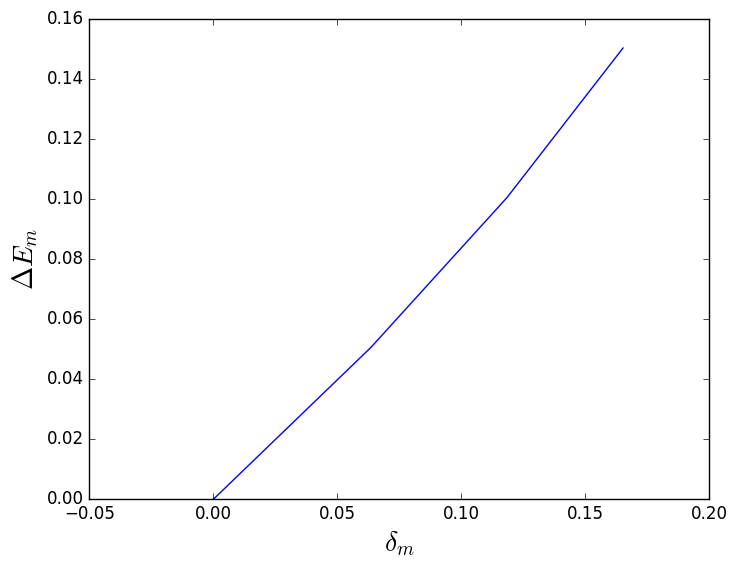

PyObject <matplotlib.text.Text object at 0x7f9957e87f98>

In [166]:
# using PyPlot
k = 16
H = Hn[k]
ev = eigs(H, nev=1)
E = ev[1][1]
psi = ev[2][:,1]
# println(ev[1][1]/k)
size = round(Int, 2^(k/2))
U,S,V= svd(reshape(psi, size, size))
delta = Array{Float64}(size)
GS_error = Array{Float64}(size)
E_approx = Array{Float64}(size)
for m in 1:size
    psiapprox = reshape(U[:,1:m]*diagm(S[1:m])*V'[1:m,:],size^2)
    delta[m] = sum(S[m+1:end].^2)
    GS_error[m] = vecnorm(psi-psiapprox)^2
    E_approx[m] = (psiapprox'* H* psiapprox ./(psiapprox'*psiapprox))[1]
end
plot(E_approx -E, delta)
plt[:xlabel](L"$\delta_m$",fontsize=20)
plt[:ylabel](L"$\Delta E_m$",fontsize=20)

## Problem 2 Hisenberg with edge filed ($B_z$)

In [173]:
Hn = cell(20)
# Htwon = cell(20)
## I am going to start from the right to build to the left
function getHkronsparse_edge_B(n, B)
    Hn[2] = 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz) + B * kron(one, sz)
#     Htwon[2] = 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz)
    Htwon = 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz)
#     H_first = Bn * kron(sz,one)
    for k=3:n
#         H_first = kron(one, H_first)
#         Htwon[k] = kron(one,Htwon[k-1])
#         Hn[k] = kron(Hn[k-1],one) + Htwon[k]
        Htwon = kron(Htwon, one)
        Hn[k] = kron(one, Hn[k-1]) + Htwon
    end
    Hn
end
function make_szn(n)
    n==1 && return sz
    szn = sz
    for k=2:n
        szn = kron(one, szn)
#         szn = kron(szn, one)
    end
    szn
end

function szn(n)
    m = 2^(n-1)
#     sparse(1:2*m,1:2*m,.5*[ones(m)...,-ones(m)...])
#     kron(sz,speye(m))
    kron(speye(m),sz)
end
Hn = getHkronsparse_edge_B(16,.1) ;
flush(STDOUT)

In [151]:
@time make_szn(16)
@time szn(16)

make_szn(5)-szn(5)

  0.002603 seconds (80 allocations: 3.004 MB)
  0.003032 seconds (24 allocations: 2.251 MB)


32x32 sparse matrix with 0 Float64 entries:

In [144]:
k = 4
H = Hn[k]
ev = eigs(H, nev=1)
E = ev[1][1]
psi = ev[2][:,1]
size = round(Int, 2^(k/2))
density_matrix = psi*psi'
psi_ij = reshape(psi, size, size)
DM_reduced = psi_ij *psi_ij'
@show trace(density_matrix)
U,S,V= svd(psi_ij)
# @show S.^2
@show trace(density_matrix*szn(k))
@show sz_exp = (psi' * szn(k) *psi)[1]
@show trace(DM_reduced*szn(Int(k/2)))

@show trace(U*diagm(S.^2)*U'*szn(Int(k/2)))
a = (U*diagm(S.^2)*U' - DM_reduced)
map!(x -> abs(x) < 1e-14 ? 0 : x , a)
find(a)

trace(density_matrix) = 0.9999999999999999
trace(density_matrix * szn(k)) = -0.06170069689323874
sz_exp = (psi' * szn(k) * psi)[1] = -0.06170069689323874
trace(DM_reduced * szn(Int(k / 2))) = -0.06170069689323881
trace(U * diagm(S .^ 2) * U' * szn(Int(k / 2))) = -0.06170069689323867


0-element Array{Int64,1}

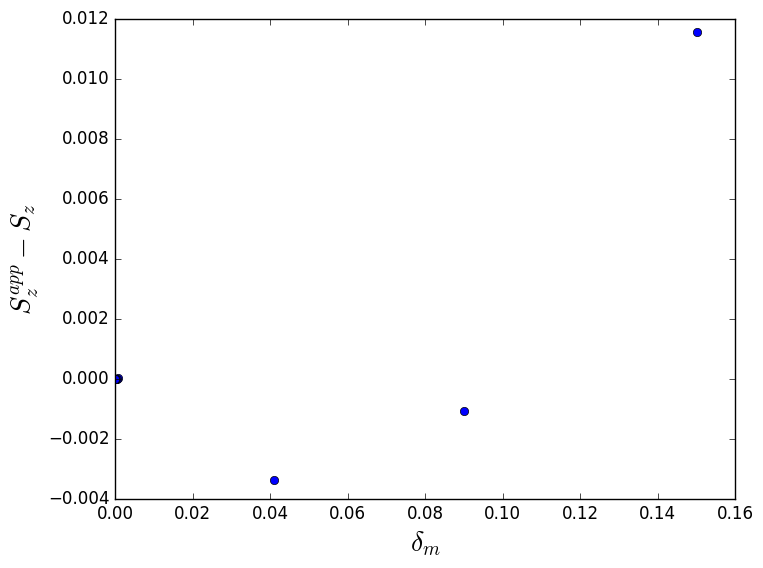

PyObject <matplotlib.text.Text object at 0x7f27f116d7f0>

In [174]:
k = 16
# size = Int(2^(k-1))
H = Hn[k]
ev = eigs(H, nev=1)
E = ev[1][1]
psi = ev[2][:,1]
sz_exp = (psi' * szn(k) *psi)[1]
size = round(Int, 2^(k/2))
psi_ij = reshape(psi, size, size)
DM_reduced = psi_ij *psi_ij'
U,S,V= svd(psi_ij)

max_m = 20

delta = Array{Float64}(0)
sz_approx = Array{Float64}(0)

for m in 1:max_m
    DM_approx = U[:,1:m]*diagm(S[1:m].^2)*U'[1:m,:]
    push!(delta, sum(S[m+1:end].^2) )
    push!(sz_approx, trace(DM_approx * szn(Int(k/2))))

end
plot( delta,sz_approx - sz_exp,"ob")
plt[:xlabel](L"$\delta_m$",fontsize=20)
plt[:ylabel](L"$S_z^{app} - S_z$",fontsize=20)

In [175]:
hcat(sz_approx - sz_exp,delta)

20x2 Array{Float64,2}:
  0.0115537    0.150028   
 -0.00107329   0.0899206  
 -0.00336131   0.0410928  
  4.16437e-5   0.000593   
 -5.16375e-7   0.000383763
 -6.94541e-6   0.00021436 
  5.01421e-6   7.37397e-5 
  9.16302e-7   1.42505e-5 
  3.78132e-8   9.83404e-6 
 -8.16651e-8   6.25993e-6 
  2.12451e-7   3.30612e-6 
 -8.59397e-8   2.39713e-6 
 -1.77616e-7   1.67735e-6 
 -1.61908e-7   1.09171e-6 
 -8.91577e-8   6.05054e-7 
  1.35719e-8   1.93722e-7 
  6.01054e-10  1.25263e-7 
 -1.58731e-9   6.99336e-8 
  1.65626e-9   2.39979e-8 
  3.153e-10    5.02118e-9 

In [39]:
using TensorOperations

In [42]:
A = ones(2,2)
B = ones(2,4,3)
C = ones(2,4,2)

@tensor begin
    D[i,ip] := A[a,ap]*B[a,s,i]*C[ap,s,ip]
end

3x2 Array{Float64,2}:
 16.0  16.0
 16.0  16.0
 16.0  16.0

In [42]:
n=100
C = zeros(n,n)
B = randn(n,n)
A = randn(n,n)
@time for i=1:n, j=1:n, k=1:n
    C[i,k] += A[i,j]*B[j,k]
end
@time A*B;

  0.620588 seconds (6.02 M allocations: 107.428 MB, 4.24% gc time)
  0.000290 seconds (7 allocations: 78.375 KB)


In [53]:
randn(2,2)

2x2 Array{Float64,2}:
 -0.0103426  -0.540344
  1.28639    -0.621715

In [62]:
ep =1
A = 2*randn(300,300)
@time map(x -> x < ep ? 0 : x , A)
@time A[find(x -> abs(x)< e,A)]=0

  0.013201 seconds (90.04 k allocations: 2.749 MB)
  0.016360 seconds (180.04 k allocations: 5.316 MB)


0

In [47]:
function f(x)
    x < ep ? 0 : x
end

f (generic function with 1 method)

In [164]:
a=[]
push!(a,3)

1-element Array{Any,1}:
 3

In [4]:
a=[1,2,3]
b = copy(a)
a[1]=5
@show a
@show b

a = [5,2,3]
b = [1,2,3]


3-element Array{Int64,1}:
 1
 2
 3

In [3]:
b[]

5